In [20]:
from imp import reload

import numpy as np
import pandas as pd
import sys,math
import sistercellclass as scc; reload(scc)
import os

import statsmodels.api as sm

import matplotlib.pyplot as plt
%matplotlib notebook
# %matplotlib inline
plt.rcParams['figure.figsize'] = [16, 9]


In [21]:
datadir = '/home/lukas/projects/sistercells/analysis/190523/'
#datadir   = '/home/lukas/projects/sistercells/experiments/SISTERS-NONSISTERS/SISTERS/'
datafiles = [os.path.join(datadir,fn) for fn in os.listdir(datadir) if os.path.splitext(fn)[1][1:].upper() == 'XLS']

#datafiles = ['/home/lukas/projects/sistercells/experiments/SISTERS-NONSISTERS/SISTERS/072818POS9_ch2t_sis2.xls']

data      = scc.SisterCellData(infiles = datafiles, debugmode = False)

In [ ]:

for dataID,filename,x in data:
    #print dataID,filename
    cdivA,cdivB = data.CellDivisionTrajectory(dataID)
    #print np.array(cdivA['generationtimeA']),np.array(cdivB['generationtimeB'])
    if dataID == 0:
        gentime = np.concatenate([np.array(cdivA['generationtimeA']),np.array(cdivB['generationtimeB'])])
    else:
        gentime = np.concatenate([gentime,np.array(cdivA['generationtimeA']),np.array(cdivB['generationtimeB'])])
    #print

#np.savetxt('tmp.txt',gentime)
#plt.hist(gentime,range=(0,2),bins=40,log=True)
#print gentime
#print max(gentime)
#gth = dict()
#for x in np.arange(0,2.1,.05):
#    gth['{:.2f}'.format(x)] = 0
#for g in gentime:
#    gth['{:.2f}'.format(g)] += 1

#print gth


In [ ]:
def autocorrelation (x) :
    """
    Compute the autocorrelation of the signal, based on the properties of the
    power spectral density of the signal.
    """
    xp = x-np.mean(x)
    f = np.fft.fft(xp)
    p = np.array([np.real(v)**2+np.imag(v)**2 for v in f])
    pi = np.fft.ifft(p)
    return np.real(pi)[:x.size/2]/np.sum(xp**2)

In [ ]:
acf = dict()
for dataID,filename,x in data:
    a,b = data.CellDivisionTrajectory(dataID)
    for k in [kk for kk in a.keys() if kk[:4]!='time']:
        if not k[:-1] in acf.keys():
            acf[k[:-1]] = list()
        if len(a[k]) > 0:
            tmpacf = autocorrelation(a[k])
            if not np.isnan(tmpacf).any():
                acf[k[:-1]].append(tmpacf)
        if len(b[k[:-1]+'B']) > 0:
            tmpacf = autocorrelation(b[k[:-1] + 'B'])
            if not np.isnan(tmpacf).any():
                acf[k[:-1]].append(tmpacf)

acf_avg = dict()
for k in acf.keys():
    maxl  = np.max([len(a) for a in acf[k]])
    count = np.zeros(maxl)
    acf_avg[k] = np.zeros(maxl)
    for a in acf[k]:
        acf_avg[k][:len(a)] += a
        count[:len(a)] += 1.
    acf_avg[k] /= count
    print k
    #print acf_avg[k]
    plt.plot(np.arange(15),acf_avg[k][:15],label = k)
plt.plot(np.arange(15),np.zeros(15))
plt.legend()
plt.show()

plt.plot(count)

for k in acf_avg.keys():
    np.savetxt('ACF_{}.txt'.format(k),np.array([np.arange(len(acf_avg[k])),acf_avg[k]]).T)

In [ ]:
def gauss(x,mean,sigma2):
    return np.exp(-(x-mean)**2/(2.*sigma2))/np.sqrt(2*math.pi*sigma2)

maxcount = 30

countdiv = np.zeros(maxcount)
for dataID,fn,x in data:
    a,b = data.CellDivisionTrajectory(dataID)
    for t in np.array(a['generationtimeA']/.05,dtype=int):
        if t < maxcount: countdiv[t] += 1
    for t in np.array(b['generationtimeB']/.05,dtype=int):
        if t < maxcount: countdiv[t] += 1

plt.plot(np.arange(maxcount),np.log10(countdiv/np.sum(countdiv)))
plt.plot(np.arange(start=0,stop=maxcount,step=.05),np.log10(gauss(np.arange(start=0,stop=maxcount,step=.05),10.968599386592668,7.605410963650854)))
plt.ylim((-np.log10(np.sum(countdiv))-.5,1))
plt.show()

In [ ]:
m = np.sum(np.arange(maxcount) * countdiv)/np.sum(countdiv)
v = np.sum(np.arange(maxcount)**2 * countdiv)/np.sum(countdiv) - (np.sum(np.arange(maxcount)*countdiv)/np.sum(countdiv))**2
print 'mean: {}, sigma2: {}'.format(m,v)

print 'count all division events: {}'.format(np.sum(countdiv,dtype=int))


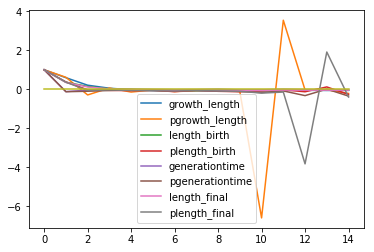

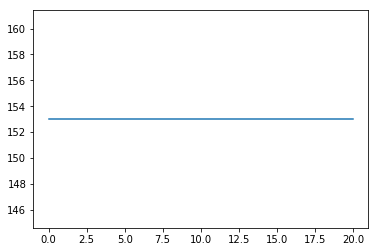

In [39]:
acflen = 20
acf  = dict()
pacf = dict()

for dataID in range(len(data)):
    a,b = data.CellDivisionTrajectory(dataID)
    for k in [kk[:-1] for kk in a.keys() if kk[:-1] != 'time']:
        if not k in acf.keys():
            acf[k]  = list()
            pacf[k] = list()
        la,lb = len(a[k + 'A']),len(b[k + 'B'])
        if len(a[k + 'A']) > acflen and not np.isnan(a[k + 'A']).any():
            acf[k].append(sm.tsa.stattools.acf(a[k + 'A'], nlags = acflen, missing = 'drop'))
            pacf[k].append(sm.tsa.stattools.pacf(a[k + 'A'], nlags = acflen))
        if len(b[k + 'B']) > acflen and not np.isnan(b[k + 'B']).any():
            acf[k].append(sm.tsa.stattools.acf(b[k + 'B'], nlags = acflen, missing = 'drop'))
            pacf[k].append(sm.tsa.stattools.pacf(b[k + 'B'], nlags = acflen))

acf_avg  = dict()
pacf_avg = dict()
for k in acf.keys():
    maxl        = np.max([len(a) for a in acf[k]])
    count       = np.zeros(maxl)
    maxlp       = np.max([len(a) for a in pacf[k]])
    countp      = np.zeros(maxlp)
    acf_avg[k]  = np.zeros(maxl)
    pacf_avg[k] = np.zeros(maxlp)
    for a in acf[k]:
        acf_avg[k][:len(a)] += a
        count[:len(a)] += 1.
    for a in pacf[k]:
        pacf_avg[k][:len(a)] += a
        countp[:len(a)] += 1.
    acf_avg[k] /= count
    pacf_avg[k] /= countp
    plt.plot(np.arange(15),acf_avg[k][:15],label = k)
    plt.plot(np.arange(15),pacf_avg[k][:15],label = 'p' + k)
plt.plot(np.arange(15),np.zeros(15))
plt.legend()
plt.show()

plt.plot(count)

for k in acf_avg.keys():
    np.savetxt('ACF_{}.txt'.format(k),np.array([np.arange(len(acf_avg[k])),acf_avg[k],pacf_avg[k]]).T)

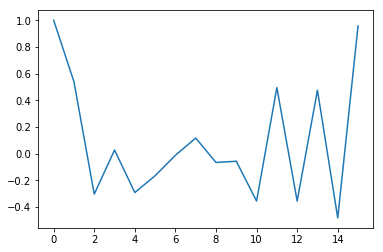

In [34]:
a,b = data.CellDivisionTrajectory(3)
#print a
plt.plot(sm.tsa.stattools.pacf(a['growth_lengthA'],nlags = 15))

In [3]:
dtdSC = np.genfromtxt('/home/lukas/projects/sistercells/analysis/190326/allDTD.SC')
dtdNSC = np.genfromtxt('/home/lukas/projects/sistercells/analysis/190326/allDTD.NSC')

print(a)

[ 0.    0.1   0.1  ... -0.15  0.   -0.05]


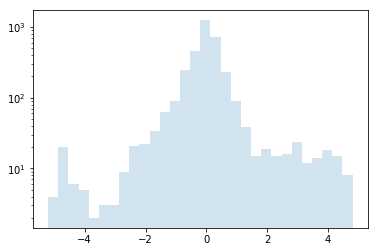

In [7]:
plt.hist(a,bins=30,alpha=.2)
plt.yscale('log')
plt.show()

In [22]:

data.__dict__['_SisterCellData__get_OTSU_from_both'] = False
data.CellDivisionTrajectory(2)

[  3  13  24  31  41  52  61  74  82 100 108 114 125 136 148 157 166 179
 189 201 211 219 228 236 246 254 260 271] 0
[  9  19  30  42  53  68  76  88 101 113 124 136 148 164 178 191 201 213
 224 237 253 264] 0


[    generationtime  growth_length  length_birth  length_final
 0             0.20       2.182991      3.370794      4.821059
 1             0.50       1.619171      2.255745      4.685951
 2             0.55       1.504837      2.240919      4.576500
 3             0.35       1.851600      2.260361      3.958896
 4             0.50       1.718082      2.058439      4.666850
 5             0.55       1.181025      2.446276      4.462014
 6             0.45       1.381663      2.384622      4.298386
 7             0.65       1.176671      2.069793      4.555542
 8             0.40       1.149547      2.404731      3.893673
 9             0.90       1.500880      1.644899      6.747882
 10            0.40       1.837795      3.113548      6.000787
 11            0.30       1.488092      3.083556      4.047848
 12            0.55       2.010782      2.119388      5.498131
 13            0.55       1.334886      2.810190      5.509355
 14            0.60       1.231815      2.945621      5

In [23]:
data.DivTimeDiffHist(dataID = 2)

[ 5.06783043e-01  3.15552912e-01  6.27929687e-01 -2.56531465e+00
  1.94482593e-02  5.45139816e-01 -1.39392097e-01  1.82579085e-01
  4.96131639e-01 -2.47494408e-02  4.31733892e-01  5.71163704e-01
  3.48150939e-01 -2.44503150e+00  7.42741631e-02  3.54266581e-01
 -1.32851085e-01  4.74365039e-01  1.03459917e-01  3.35045531e-01
  1.14175366e-01  4.92195320e-01  4.18680738e-01  1.01969004e-01
 -2.31613896e+00  9.88877799e-02  4.28307332e-01  5.30709411e-01
  1.15021284e-01 -8.10577727e-02  6.06667357e-01 -1.90045756e+00
  2.36567356e-01  1.72963675e-01  3.40238750e-01  1.63885209e-01
  2.45845477e-02  4.16946540e-01  4.83868617e-01  1.25327738e-01
  6.44029367e-01 -2.22057480e+00  1.63546272e-01  1.12197473e-01
  2.46039308e-01  4.24057445e-02 -1.09602257e-01  5.22732594e-01
  3.71297372e-01 -5.21381551e-02  4.69680838e-01  2.49578878e-01
 -2.07739180e+00  3.26994213e-01  2.69677011e-01  1.17874524e-01
  5.26576130e-02  3.30908199e-03  8.32589524e-01  4.21459056e-02
  2.68515930e-01 -2.22859

(array([ 5.06783043e-01,  3.15552912e-01,  6.27929687e-01, -2.56531465e+00,
         1.94482593e-02,  5.45139816e-01, -1.39392097e-01,  1.82579085e-01,
         4.96131639e-01, -2.47494408e-02,  4.31733892e-01,  5.71163704e-01,
         3.48150939e-01, -2.44503150e+00,  7.42741631e-02,  3.54266581e-01,
        -1.32851085e-01,  4.74365039e-01,  1.03459917e-01,  3.35045531e-01,
         1.14175366e-01,  4.92195320e-01,  4.18680738e-01,  1.01969004e-01,
        -2.31613896e+00,  9.88877799e-02,  4.28307332e-01,  5.30709411e-01,
         1.15021284e-01, -8.10577727e-02,  6.06667357e-01, -1.90045756e+00,
         2.36567356e-01,  1.72963675e-01,  3.40238750e-01,  1.63885209e-01,
         2.45845477e-02,  4.16946540e-01,  4.83868617e-01,  1.25327738e-01,
         6.44029367e-01, -2.22057480e+00,  1.63546272e-01,  1.12197473e-01,
         2.46039308e-01,  4.24057445e-02, -1.09602257e-01,  5.22732594e-01,
         3.71297372e-01, -5.21381551e-02,  4.69680838e-01,  2.49578878e-01,
        -2.0